In [1]:
import matplotlib.pyplot as plt
import numpy as np
import casperfpga
import time
import pandas as pd
from cr_functions import *

This notebook adapts the code from test_gpio_stability.py to do tests with all 11 boards.

### Note 23 March:  
This appeared to be working from the first short test. Running 500 tests was taking weirdly long and so I stopped it part way through and saved the results.  The last part of the notebook hasn't been re-run yet.

In [2]:
#Reset the trigger counter
def reset_trigger_counter_all(brds):
        [setvalue(brd,"trig_debug_reset","cr_registers.xlsx",1) for brd in brds]
        time.sleep(0.01)
        [setvalue(brd,"trig_debug_reset","cr_registers.xlsx",0) for brd in brds]
        return

#reset the trigger timer
def reset_trigger_timer_all(brds):
        [setvalue(brd,"trig_debug_timer_reset","cr_registers.xlsx",1) for brd in brds]
        time.sleep(0.01)
        [setvalue(brd,"trig_debug_timer_reset","cr_registers.xlsx",0) for brd in brds]
        return

#set all boards to listen
def reset_to_listen_all(brds):
        [setvalue(brd,"reset_to_listen","cr_registers.xlsx",0) for brd in brds]
        time.sleep(0.01)
        [setvalue(brd,"reset_to_listen","cr_registers.xlsx",1) for brd in brds]
        return
    
#read the readout state value on all the boards
def read_state_value_all(brds):
        return([getvalue(brd,"readout_state_value","cr_registers.xlsx") for brd in brds])
        

#send a trigger to one board
def trigger(board):
        #board is a casperfpga object
        setvalue(board,"send_trigger","cr_registers.xlsx",0)
        time.sleep(0.01)
        setvalue(board,"send_trigger","cr_registers.xlsx",1)
        return

#read the trigger counter on all the boards
def read_trigger_counter_all(brds):
        return([getvalue(brd,"count_triggers","cr_registers.xlsx") for brd in brds])


def time_trigger_communication(board,brds):
        #board is the board to send the trigger to
        reset_trigger_counter_all(brds)
        reset_trigger_timer_all(brds)
        reset_to_listen_all(brds)
        initialstates=read_state_value_all(brds)
        trigger(board)
        time.sleep(0.1)
        timer_value=getvalue(board,"trig_debug_timer","cr_registers.xlsx")
        counts=read_trigger_counter_all(brds)
        finalstates=read_state_value_all(brds)
        #return np.asarray([initialstate9,initialstate11,initialstate12,timer_value,count9,count11,count12,finalstate9,finalstate11,finalstate12])
        return initialstates,timer_value,counts,finalstates

In [3]:
#connect to boards -- assuming firmware is already loaded


brdnames = ['snap01','snap02','snap03','snap04','snap05','snap06','snap07','snap08','snap09','snap10','snap11']
print("Connecting to boards")
brds = [casperfpga.CasperFpga(n) for n in brdnames]
[print(brdnames[i],'Is connected? ', brds[i].is_connected()) for i in range(len(brds))]

Connecting to boards
snap01 Is connected?  True
snap02 Is connected?  True
snap03 Is connected?  True
snap04 Is connected?  True
snap05 Is connected?  True
snap06 Is connected?  True
snap07 Is connected?  True
snap08 Is connected?  True
snap09 Is connected?  True
snap10 Is connected?  True
snap11 Is connected?  True


[None, None, None, None, None, None, None, None, None, None, None]

## Test sending trigger around the loop
Below, I run a test where all the boards are reset to listen and then one board receives a trigger. They should all receive it, and then I can time how long the trigger takes to go around the loop by reading the timer value.  

In [4]:
i=1
for brd in brds:
    print( i)
    initialstates,timer_value,counts,finalstates = time_trigger_communication(brd,brds)
    print('Initial states',initialstates)
    print('Timer value',timer_value)
    print('Counts',counts)
    print('Final states',finalstates)
    i+=1

1
Initial states [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Timer value 136
Counts [2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Final states [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2
Initial states [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Timer value 137
Counts [1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Final states [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
3
Initial states [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Timer value 137
Counts [1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1]
Final states [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
4
Initial states [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Timer value 137
Counts [1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1]
Final states [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
5
Initial states [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Timer value 137
Counts [1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1]
Final states [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
6
Initial states [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Timer value 137
Counts [1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1]
Final states [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
7
Initial states [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Timer value 137
Cou

Next, I check whether the boards are successfully resetting to listen and waiting for a trigger.  

In [20]:
for i in range(20):
    reset_to_listen_all(brds)
    print(read_state_value_all(brds))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Next, I reset each board to listen and read its readout state value a couple times, and its trigger count. All should stay in listening state and none should see any new triggers. 

In [22]:
for i in range(10):      
    reset_trigger_counter_all(brds)
    reset_to_listen_all(brds)
    print(read_state_value_all(brds),read_trigger_counter_all(brds))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


# Repeat the loop test many times

In [28]:
fname_suffix='23-Mar-2023a'


In [26]:
n=500
initialstates=np.zeros((n,len(brds),len(brds)),dtype="int32")
finalstates=np.zeros((n,len(brds),len(brds)),dtype="int32")
countresults = np.zeros((n,len(brds),len(brds)),dtype="int32")
timervalues = np.zeros((n,len(brds)))


print("doing test " + str(n) + " times")
for i in range(n):
    for j in range(len(brds)):
        brd=brds[j]
        initstat,timval,counts,finstat=time_trigger_communication(brd,brds)
        initialstates[i,j,:] = np.asarray(initstat)
        finalstates[i,j,:] = np.asarray(finstat)
        countresults[i,j,:] = np.asarray(counts)
        timervalues[i,j] = timval

        if i==100:
                print("100th test")
        if i==200:
                print("200th test")
        if i==300:
                print("300th test")
        if i==400:
                print("400th test")

np.save('GPIOloopresults_initialstates'+fname_suffix,initialstates)
np.save('GPIOloopresults_finalstates'+fname_suffix,finalstates)
np.save('GPIOloopresults_countresults'+fname_suffix,countresults)
np.save('GPIOloopresults_timervalues'+fname_suffix,timervalues)

doing test 500 times
100th test
100th test
100th test
100th test
100th test
100th test
100th test
100th test
100th test
100th test
100th test


KeyboardInterrupt: 

In [31]:
np.save('GPIOloopresults_initialstates'+fname_suffix,initialstates)
np.save('GPIOloopresults_finalstates'+fname_suffix,finalstates)
np.save('GPIOloopresults_countresults'+fname_suffix,countresults)
np.save('GPIOloopresults_timervalues'+fname_suffix,timervalues)

### Analyse results

In [34]:
 initialstatessresults= np.load("GPIOloopresults_initialstates23-Mar-2023a.npy")
finalstatessresults= np.load("GPIOloopresults_finalstates23-Mar-2023a.npy")

countresults= np.load("GPIOloopresults_countresults23-Mar-2023a.npy")
timervaluesresults= np.load("GPIOloopresults_timervalues23-Mar-2023a.npy")

print(initialstatessresults.shape)
print(finalstatessresults.shape)
print(timervaluesresults.shape)
print(countresults.shape)


(500, 11, 11)
(500, 11, 11)
(500, 11)
(500, 11, 11)


In [35]:
print(initialstatessresults.max(),initialstatessresults.min())
print(finalstatessresults.max(), finalstatessresults.min())


0 0
1 0


The above means that every board on every iteration started in the listening state and finished in the readout state, as it should (except that board 2 is probably reading out data and going back to listening since it's ethernet is enabled from a previoius test).  Below, I confirmed that every board received exactly two triggers when it received the initial trigger and exactly one trigger otherwise.

112 0 1 0
113 0 1 0
114 0 1 0
115 0 1 0
116 0 1 0
117 0 1 0
118 0 1 0
119 0 1 0
120 0 1 0
121 0 1 0
122 0 1 0
123 0 1 0
124 0 1 0
125 0 1 0
126 0 1 0
127 0 1 0
128 0 1 0
129 0 1 0
130 0 1 0
131 0 1 0
132 0 1 0
133 0 1 0
134 0 1 0
135 0 1 0
136 0 1 0
137 0 1 0
138 0 1 0
139 0 1 0
140 0 1 0
141 0 1 0
142 0 1 0
143 0 1 0
144 0 1 0
145 0 1 0
146 0 1 0
147 0 1 0
148 0 1 0
149 0 1 0
150 0 1 0
151 0 1 0
152 0 1 0
153 0 1 0
154 0 1 0
155 0 1 0
156 0 1 0
157 0 1 0
158 0 1 0
159 0 1 0
160 0 1 0
161 0 1 0
162 0 1 0
163 0 1 0
164 0 1 0
165 0 1 0
166 0 1 0
167 0 1 0
168 0 1 0
169 0 1 0
170 0 1 0
171 0 1 0
172 0 1 0
173 0 1 0
174 0 1 0
175 0 1 0
176 0 1 0
177 0 1 0
178 0 1 0
179 0 1 0
180 0 1 0
181 0 1 0
182 0 1 0
183 0 1 0
184 0 1 0
185 0 1 0
186 0 1 0
187 0 1 0
188 0 1 0
189 0 1 0
190 0 1 0
191 0 1 0
192 0 1 0
193 0 1 0
194 0 1 0
195 0 1 0
196 0 1 0
197 0 1 0
198 0 1 0
199 0 1 0
200 0 1 0
201 0 1 0
202 0 1 0
203 0 1 0
204 0 1 0
205 0 1 0
206 0 1 0
207 0 1 0
208 0 1 0
209 0 1 0
210 0 1 0
211 0 1 0


217 0 3 0
218 0 3 0
219 0 3 0
220 0 3 0
221 0 3 0
222 0 3 0
223 0 3 0
224 0 3 0
225 0 3 0
226 0 3 0
227 0 3 0
228 0 3 0
229 0 3 0
230 0 3 0
231 0 3 0
232 0 3 0
233 0 3 0
234 0 3 0
235 0 3 0
236 0 3 0
237 0 3 0
238 0 3 0
239 0 3 0
240 0 3 0
241 0 3 0
242 0 3 0
243 0 3 0
244 0 3 0
245 0 3 0
246 0 3 0
247 0 3 0
248 0 3 0
249 0 3 0
250 0 3 0
251 0 3 0
252 0 3 0
253 0 3 0
254 0 3 0
255 0 3 0
256 0 3 0
257 0 3 0
258 0 3 0
259 0 3 0
260 0 3 0
261 0 3 0
262 0 3 0
263 0 3 0
264 0 3 0
265 0 3 0
266 0 3 0
267 0 3 0
268 0 3 0
269 0 3 0
270 0 3 0
271 0 3 0
272 0 3 0
273 0 3 0
274 0 3 0
275 0 3 0
276 0 3 0
277 0 3 0
278 0 3 0
279 0 3 0
280 0 3 0
281 0 3 0
282 0 3 0
283 0 3 0
284 0 3 0
285 0 3 0
286 0 3 0
287 0 3 0
288 0 3 0
289 0 3 0
290 0 3 0
291 0 3 0
292 0 3 0
293 0 3 0
294 0 3 0
295 0 3 0
296 0 3 0
297 0 3 0
298 0 3 0
299 0 3 0
300 0 3 0
301 0 3 0
302 0 3 0
303 0 3 0
304 0 3 0
305 0 3 0
306 0 3 0
307 0 3 0
308 0 3 0
309 0 3 0
310 0 3 0
311 0 3 0
312 0 3 0
313 0 3 0
314 0 3 0
315 0 3 0
316 0 3 0


155 0 7 0
156 0 7 0
157 0 7 0
158 0 7 0
159 0 7 0
160 0 7 0
161 0 7 0
162 0 7 0
163 0 7 0
164 0 7 0
165 0 7 0
166 0 7 0
167 0 7 0
168 0 7 0
169 0 7 0
170 0 7 0
171 0 7 0
172 0 7 0
173 0 7 0
174 0 7 0
175 0 7 0
176 0 7 0
177 0 7 0
178 0 7 0
179 0 7 0
180 0 7 0
181 0 7 0
182 0 7 0
183 0 7 0
184 0 7 0
185 0 7 0
186 0 7 0
187 0 7 0
188 0 7 0
189 0 7 0
190 0 7 0
191 0 7 0
192 0 7 0
193 0 7 0
194 0 7 0
195 0 7 0
196 0 7 0
197 0 7 0
198 0 7 0
199 0 7 0
200 0 7 0
201 0 7 0
202 0 7 0
203 0 7 0
204 0 7 0
205 0 7 0
206 0 7 0
207 0 7 0
208 0 7 0
209 0 7 0
210 0 7 0
211 0 7 0
212 0 7 0
213 0 7 0
214 0 7 0
215 0 7 0
216 0 7 0
217 0 7 0
218 0 7 0
219 0 7 0
220 0 7 0
221 0 7 0
222 0 7 0
223 0 7 0
224 0 7 0
225 0 7 0
226 0 7 0
227 0 7 0
228 0 7 0
229 0 7 0
230 0 7 0
231 0 7 0
232 0 7 0
233 0 7 0
234 0 7 0
235 0 7 0
236 0 7 0
237 0 7 0
238 0 7 0
239 0 7 0
240 0 7 0
241 0 7 0
242 0 7 0
243 0 7 0
244 0 7 0
245 0 7 0
246 0 7 0
247 0 7 0
248 0 7 0
249 0 7 0
250 0 7 0
251 0 7 0
252 0 7 0
253 0 7 0
254 0 7 0


352 0 9 0
353 0 9 0
354 0 9 0
355 0 9 0
356 0 9 0
357 0 9 0
358 0 9 0
359 0 9 0
360 0 9 0
361 0 9 0
362 0 9 0
363 0 9 0
364 0 9 0
365 0 9 0
366 0 9 0
367 0 9 0
368 0 9 0
369 0 9 0
370 0 9 0
371 0 9 0
372 0 9 0
373 0 9 0
374 0 9 0
375 0 9 0
376 0 9 0
377 0 9 0
378 0 9 0
379 0 9 0
380 0 9 0
381 0 9 0
382 0 9 0
383 0 9 0
384 0 9 0
385 0 9 0
386 0 9 0
387 0 9 0
388 0 9 0
389 0 9 0
390 0 9 0
391 0 9 0
392 0 9 0
393 0 9 0
394 0 9 0
395 0 9 0
396 0 9 0
397 0 9 0
398 0 9 0
399 0 9 0
400 0 9 0
401 0 9 0
402 0 9 0
403 0 9 0
404 0 9 0
405 0 9 0
406 0 9 0
407 0 9 0
408 0 9 0
409 0 9 0
410 0 9 0
411 0 9 0
412 0 9 0
413 0 9 0
414 0 9 0
415 0 9 0
416 0 9 0
417 0 9 0
418 0 9 0
419 0 9 0
420 0 9 0
421 0 9 0
422 0 9 0
423 0 9 0
424 0 9 0
425 0 9 0
426 0 9 0
427 0 9 0
428 0 9 0
429 0 9 0
430 0 9 0
431 0 9 0
432 0 9 0
433 0 9 0
434 0 9 0
435 0 9 0
436 0 9 0
437 0 9 0
438 0 9 0
439 0 9 0
440 0 9 0
441 0 9 0
442 0 9 0
443 0 9 0
444 0 9 0
445 0 9 0
446 0 9 0
447 0 9 0
448 0 9 0
449 0 9 0
450 0 9 0
451 0 9 0


187 1 2 0
188 1 2 0
189 1 2 0
190 1 2 0
191 1 2 0
192 1 2 0
193 1 2 0
194 1 2 0
195 1 2 0
196 1 2 0
197 1 2 0
198 1 2 0
199 1 2 0
200 1 2 0
201 1 2 0
202 1 2 0
203 1 2 0
204 1 2 0
205 1 2 0
206 1 2 0
207 1 2 0
208 1 2 0
209 1 2 0
210 1 2 0
211 1 2 0
212 1 2 0
213 1 2 0
214 1 2 0
215 1 2 0
216 1 2 0
217 1 2 0
218 1 2 0
219 1 2 0
220 1 2 0
221 1 2 0
222 1 2 0
223 1 2 0
224 1 2 0
225 1 2 0
226 1 2 0
227 1 2 0
228 1 2 0
229 1 2 0
230 1 2 0
231 1 2 0
232 1 2 0
233 1 2 0
234 1 2 0
235 1 2 0
236 1 2 0
237 1 2 0
238 1 2 0
239 1 2 0
240 1 2 0
241 1 2 0
242 1 2 0
243 1 2 0
244 1 2 0
245 1 2 0
246 1 2 0
247 1 2 0
248 1 2 0
249 1 2 0
250 1 2 0
251 1 2 0
252 1 2 0
253 1 2 0
254 1 2 0
255 1 2 0
256 1 2 0
257 1 2 0
258 1 2 0
259 1 2 0
260 1 2 0
261 1 2 0
262 1 2 0
263 1 2 0
264 1 2 0
265 1 2 0
266 1 2 0
267 1 2 0
268 1 2 0
269 1 2 0
270 1 2 0
271 1 2 0
272 1 2 0
273 1 2 0
274 1 2 0
275 1 2 0
276 1 2 0
277 1 2 0
278 1 2 0
279 1 2 0
280 1 2 0
281 1 2 0
282 1 2 0
283 1 2 0
284 1 2 0
285 1 2 0
286 1 2 0


494 1 4 0
495 1 4 0
496 1 4 0
497 1 4 0
498 1 4 0
499 1 4 0
112 1 5 0
113 1 5 0
114 1 5 0
115 1 5 0
116 1 5 0
117 1 5 0
118 1 5 0
119 1 5 0
120 1 5 0
121 1 5 0
122 1 5 0
123 1 5 0
124 1 5 0
125 1 5 0
126 1 5 0
127 1 5 0
128 1 5 0
129 1 5 0
130 1 5 0
131 1 5 0
132 1 5 0
133 1 5 0
134 1 5 0
135 1 5 0
136 1 5 0
137 1 5 0
138 1 5 0
139 1 5 0
140 1 5 0
141 1 5 0
142 1 5 0
143 1 5 0
144 1 5 0
145 1 5 0
146 1 5 0
147 1 5 0
148 1 5 0
149 1 5 0
150 1 5 0
151 1 5 0
152 1 5 0
153 1 5 0
154 1 5 0
155 1 5 0
156 1 5 0
157 1 5 0
158 1 5 0
159 1 5 0
160 1 5 0
161 1 5 0
162 1 5 0
163 1 5 0
164 1 5 0
165 1 5 0
166 1 5 0
167 1 5 0
168 1 5 0
169 1 5 0
170 1 5 0
171 1 5 0
172 1 5 0
173 1 5 0
174 1 5 0
175 1 5 0
176 1 5 0
177 1 5 0
178 1 5 0
179 1 5 0
180 1 5 0
181 1 5 0
182 1 5 0
183 1 5 0
184 1 5 0
185 1 5 0
186 1 5 0
187 1 5 0
188 1 5 0
189 1 5 0
190 1 5 0
191 1 5 0
192 1 5 0
193 1 5 0
194 1 5 0
195 1 5 0
196 1 5 0
197 1 5 0
198 1 5 0
199 1 5 0
200 1 5 0
201 1 5 0
202 1 5 0
203 1 5 0
204 1 5 0
205 1 5 0


203 1 7 0
204 1 7 0
205 1 7 0
206 1 7 0
207 1 7 0
208 1 7 0
209 1 7 0
210 1 7 0
211 1 7 0
212 1 7 0
213 1 7 0
214 1 7 0
215 1 7 0
216 1 7 0
217 1 7 0
218 1 7 0
219 1 7 0
220 1 7 0
221 1 7 0
222 1 7 0
223 1 7 0
224 1 7 0
225 1 7 0
226 1 7 0
227 1 7 0
228 1 7 0
229 1 7 0
230 1 7 0
231 1 7 0
232 1 7 0
233 1 7 0
234 1 7 0
235 1 7 0
236 1 7 0
237 1 7 0
238 1 7 0
239 1 7 0
240 1 7 0
241 1 7 0
242 1 7 0
243 1 7 0
244 1 7 0
245 1 7 0
246 1 7 0
247 1 7 0
248 1 7 0
249 1 7 0
250 1 7 0
251 1 7 0
252 1 7 0
253 1 7 0
254 1 7 0
255 1 7 0
256 1 7 0
257 1 7 0
258 1 7 0
259 1 7 0
260 1 7 0
261 1 7 0
262 1 7 0
263 1 7 0
264 1 7 0
265 1 7 0
266 1 7 0
267 1 7 0
268 1 7 0
269 1 7 0
270 1 7 0
271 1 7 0
272 1 7 0
273 1 7 0
274 1 7 0
275 1 7 0
276 1 7 0
277 1 7 0
278 1 7 0
279 1 7 0
280 1 7 0
281 1 7 0
282 1 7 0
283 1 7 0
284 1 7 0
285 1 7 0
286 1 7 0
287 1 7 0
288 1 7 0
289 1 7 0
290 1 7 0
291 1 7 0
292 1 7 0
293 1 7 0
294 1 7 0
295 1 7 0
296 1 7 0
297 1 7 0
298 1 7 0
299 1 7 0
300 1 7 0
301 1 7 0
302 1 7 0


256 1 9 0
257 1 9 0
258 1 9 0
259 1 9 0
260 1 9 0
261 1 9 0
262 1 9 0
263 1 9 0
264 1 9 0
265 1 9 0
266 1 9 0
267 1 9 0
268 1 9 0
269 1 9 0
270 1 9 0
271 1 9 0
272 1 9 0
273 1 9 0
274 1 9 0
275 1 9 0
276 1 9 0
277 1 9 0
278 1 9 0
279 1 9 0
280 1 9 0
281 1 9 0
282 1 9 0
283 1 9 0
284 1 9 0
285 1 9 0
286 1 9 0
287 1 9 0
288 1 9 0
289 1 9 0
290 1 9 0
291 1 9 0
292 1 9 0
293 1 9 0
294 1 9 0
295 1 9 0
296 1 9 0
297 1 9 0
298 1 9 0
299 1 9 0
300 1 9 0
301 1 9 0
302 1 9 0
303 1 9 0
304 1 9 0
305 1 9 0
306 1 9 0
307 1 9 0
308 1 9 0
309 1 9 0
310 1 9 0
311 1 9 0
312 1 9 0
313 1 9 0
314 1 9 0
315 1 9 0
316 1 9 0
317 1 9 0
318 1 9 0
319 1 9 0
320 1 9 0
321 1 9 0
322 1 9 0
323 1 9 0
324 1 9 0
325 1 9 0
326 1 9 0
327 1 9 0
328 1 9 0
329 1 9 0
330 1 9 0
331 1 9 0
332 1 9 0
333 1 9 0
334 1 9 0
335 1 9 0
336 1 9 0
337 1 9 0
338 1 9 0
339 1 9 0
340 1 9 0
341 1 9 0
342 1 9 0
343 1 9 0
344 1 9 0
345 1 9 0
346 1 9 0
347 1 9 0
348 1 9 0
349 1 9 0
350 1 9 0
351 1 9 0
352 1 9 0
353 1 9 0
354 1 9 0
355 1 9 0


338 2 0 0
339 2 0 0
340 2 0 0
341 2 0 0
342 2 0 0
343 2 0 0
344 2 0 0
345 2 0 0
346 2 0 0
347 2 0 0
348 2 0 0
349 2 0 0
350 2 0 0
351 2 0 0
352 2 0 0
353 2 0 0
354 2 0 0
355 2 0 0
356 2 0 0
357 2 0 0
358 2 0 0
359 2 0 0
360 2 0 0
361 2 0 0
362 2 0 0
363 2 0 0
364 2 0 0
365 2 0 0
366 2 0 0
367 2 0 0
368 2 0 0
369 2 0 0
370 2 0 0
371 2 0 0
372 2 0 0
373 2 0 0
374 2 0 0
375 2 0 0
376 2 0 0
377 2 0 0
378 2 0 0
379 2 0 0
380 2 0 0
381 2 0 0
382 2 0 0
383 2 0 0
384 2 0 0
385 2 0 0
386 2 0 0
387 2 0 0
388 2 0 0
389 2 0 0
390 2 0 0
391 2 0 0
392 2 0 0
393 2 0 0
394 2 0 0
395 2 0 0
396 2 0 0
397 2 0 0
398 2 0 0
399 2 0 0
400 2 0 0
401 2 0 0
402 2 0 0
403 2 0 0
404 2 0 0
405 2 0 0
406 2 0 0
407 2 0 0
408 2 0 0
409 2 0 0
410 2 0 0
411 2 0 0
412 2 0 0
413 2 0 0
414 2 0 0
415 2 0 0
416 2 0 0
417 2 0 0
418 2 0 0
419 2 0 0
420 2 0 0
421 2 0 0
422 2 0 0
423 2 0 0
424 2 0 0
425 2 0 0
426 2 0 0
427 2 0 0
428 2 0 0
429 2 0 0
430 2 0 0
431 2 0 0
432 2 0 0
433 2 0 0
434 2 0 0
435 2 0 0
436 2 0 0
437 2 0 0


404 2 3 0
405 2 3 0
406 2 3 0
407 2 3 0
408 2 3 0
409 2 3 0
410 2 3 0
411 2 3 0
412 2 3 0
413 2 3 0
414 2 3 0
415 2 3 0
416 2 3 0
417 2 3 0
418 2 3 0
419 2 3 0
420 2 3 0
421 2 3 0
422 2 3 0
423 2 3 0
424 2 3 0
425 2 3 0
426 2 3 0
427 2 3 0
428 2 3 0
429 2 3 0
430 2 3 0
431 2 3 0
432 2 3 0
433 2 3 0
434 2 3 0
435 2 3 0
436 2 3 0
437 2 3 0
438 2 3 0
439 2 3 0
440 2 3 0
441 2 3 0
442 2 3 0
443 2 3 0
444 2 3 0
445 2 3 0
446 2 3 0
447 2 3 0
448 2 3 0
449 2 3 0
450 2 3 0
451 2 3 0
452 2 3 0
453 2 3 0
454 2 3 0
455 2 3 0
456 2 3 0
457 2 3 0
458 2 3 0
459 2 3 0
460 2 3 0
461 2 3 0
462 2 3 0
463 2 3 0
464 2 3 0
465 2 3 0
466 2 3 0
467 2 3 0
468 2 3 0
469 2 3 0
470 2 3 0
471 2 3 0
472 2 3 0
473 2 3 0
474 2 3 0
475 2 3 0
476 2 3 0
477 2 3 0
478 2 3 0
479 2 3 0
480 2 3 0
481 2 3 0
482 2 3 0
483 2 3 0
484 2 3 0
485 2 3 0
486 2 3 0
487 2 3 0
488 2 3 0
489 2 3 0
490 2 3 0
491 2 3 0
492 2 3 0
493 2 3 0
494 2 3 0
495 2 3 0
496 2 3 0
497 2 3 0
498 2 3 0
499 2 3 0
111 2 4 0
112 2 4 0
113 2 4 0
114 2 4 0


249 2 6 0
250 2 6 0
251 2 6 0
252 2 6 0
253 2 6 0
254 2 6 0
255 2 6 0
256 2 6 0
257 2 6 0
258 2 6 0
259 2 6 0
260 2 6 0
261 2 6 0
262 2 6 0
263 2 6 0
264 2 6 0
265 2 6 0
266 2 6 0
267 2 6 0
268 2 6 0
269 2 6 0
270 2 6 0
271 2 6 0
272 2 6 0
273 2 6 0
274 2 6 0
275 2 6 0
276 2 6 0
277 2 6 0
278 2 6 0
279 2 6 0
280 2 6 0
281 2 6 0
282 2 6 0
283 2 6 0
284 2 6 0
285 2 6 0
286 2 6 0
287 2 6 0
288 2 6 0
289 2 6 0
290 2 6 0
291 2 6 0
292 2 6 0
293 2 6 0
294 2 6 0
295 2 6 0
296 2 6 0
297 2 6 0
298 2 6 0
299 2 6 0
300 2 6 0
301 2 6 0
302 2 6 0
303 2 6 0
304 2 6 0
305 2 6 0
306 2 6 0
307 2 6 0
308 2 6 0
309 2 6 0
310 2 6 0
311 2 6 0
312 2 6 0
313 2 6 0
314 2 6 0
315 2 6 0
316 2 6 0
317 2 6 0
318 2 6 0
319 2 6 0
320 2 6 0
321 2 6 0
322 2 6 0
323 2 6 0
324 2 6 0
325 2 6 0
326 2 6 0
327 2 6 0
328 2 6 0
329 2 6 0
330 2 6 0
331 2 6 0
332 2 6 0
333 2 6 0
334 2 6 0
335 2 6 0
336 2 6 0
337 2 6 0
338 2 6 0
339 2 6 0
340 2 6 0
341 2 6 0
342 2 6 0
343 2 6 0
344 2 6 0
345 2 6 0
346 2 6 0
347 2 6 0
348 2 6 0


346 2 8 0
347 2 8 0
348 2 8 0
349 2 8 0
350 2 8 0
351 2 8 0
352 2 8 0
353 2 8 0
354 2 8 0
355 2 8 0
356 2 8 0
357 2 8 0
358 2 8 0
359 2 8 0
360 2 8 0
361 2 8 0
362 2 8 0
363 2 8 0
364 2 8 0
365 2 8 0
366 2 8 0
367 2 8 0
368 2 8 0
369 2 8 0
370 2 8 0
371 2 8 0
372 2 8 0
373 2 8 0
374 2 8 0
375 2 8 0
376 2 8 0
377 2 8 0
378 2 8 0
379 2 8 0
380 2 8 0
381 2 8 0
382 2 8 0
383 2 8 0
384 2 8 0
385 2 8 0
386 2 8 0
387 2 8 0
388 2 8 0
389 2 8 0
390 2 8 0
391 2 8 0
392 2 8 0
393 2 8 0
394 2 8 0
395 2 8 0
396 2 8 0
397 2 8 0
398 2 8 0
399 2 8 0
400 2 8 0
401 2 8 0
402 2 8 0
403 2 8 0
404 2 8 0
405 2 8 0
406 2 8 0
407 2 8 0
408 2 8 0
409 2 8 0
410 2 8 0
411 2 8 0
412 2 8 0
413 2 8 0
414 2 8 0
415 2 8 0
416 2 8 0
417 2 8 0
418 2 8 0
419 2 8 0
420 2 8 0
421 2 8 0
422 2 8 0
423 2 8 0
424 2 8 0
425 2 8 0
426 2 8 0
427 2 8 0
428 2 8 0
429 2 8 0
430 2 8 0
431 2 8 0
432 2 8 0
433 2 8 0
434 2 8 0
435 2 8 0
436 2 8 0
437 2 8 0
438 2 8 0
439 2 8 0
440 2 8 0
441 2 8 0
442 2 8 0
443 2 8 0
444 2 8 0
445 2 8 0


139 3 0 0
140 3 0 0
141 3 0 0
142 3 0 0
143 3 0 0
144 3 0 0
145 3 0 0
146 3 0 0
147 3 0 0
148 3 0 0
149 3 0 0
150 3 0 0
151 3 0 0
152 3 0 0
153 3 0 0
154 3 0 0
155 3 0 0
156 3 0 0
157 3 0 0
158 3 0 0
159 3 0 0
160 3 0 0
161 3 0 0
162 3 0 0
163 3 0 0
164 3 0 0
165 3 0 0
166 3 0 0
167 3 0 0
168 3 0 0
169 3 0 0
170 3 0 0
171 3 0 0
172 3 0 0
173 3 0 0
174 3 0 0
175 3 0 0
176 3 0 0
177 3 0 0
178 3 0 0
179 3 0 0
180 3 0 0
181 3 0 0
182 3 0 0
183 3 0 0
184 3 0 0
185 3 0 0
186 3 0 0
187 3 0 0
188 3 0 0
189 3 0 0
190 3 0 0
191 3 0 0
192 3 0 0
193 3 0 0
194 3 0 0
195 3 0 0
196 3 0 0
197 3 0 0
198 3 0 0
199 3 0 0
200 3 0 0
201 3 0 0
202 3 0 0
203 3 0 0
204 3 0 0
205 3 0 0
206 3 0 0
207 3 0 0
208 3 0 0
209 3 0 0
210 3 0 0
211 3 0 0
212 3 0 0
213 3 0 0
214 3 0 0
215 3 0 0
216 3 0 0
217 3 0 0
218 3 0 0
219 3 0 0
220 3 0 0
221 3 0 0
222 3 0 0
223 3 0 0
224 3 0 0
225 3 0 0
226 3 0 0
227 3 0 0
228 3 0 0
229 3 0 0
230 3 0 0
231 3 0 0
232 3 0 0
233 3 0 0
234 3 0 0
235 3 0 0
236 3 0 0
237 3 0 0
238 3 0 0


372 3 5 0
373 3 5 0
374 3 5 0
375 3 5 0
376 3 5 0
377 3 5 0
378 3 5 0
379 3 5 0
380 3 5 0
381 3 5 0
382 3 5 0
383 3 5 0
384 3 5 0
385 3 5 0
386 3 5 0
387 3 5 0
388 3 5 0
389 3 5 0
390 3 5 0
391 3 5 0
392 3 5 0
393 3 5 0
394 3 5 0
395 3 5 0
396 3 5 0
397 3 5 0
398 3 5 0
399 3 5 0
400 3 5 0
401 3 5 0
402 3 5 0
403 3 5 0
404 3 5 0
405 3 5 0
406 3 5 0
407 3 5 0
408 3 5 0
409 3 5 0
410 3 5 0
411 3 5 0
412 3 5 0
413 3 5 0
414 3 5 0
415 3 5 0
416 3 5 0
417 3 5 0
418 3 5 0
419 3 5 0
420 3 5 0
421 3 5 0
422 3 5 0
423 3 5 0
424 3 5 0
425 3 5 0
426 3 5 0
427 3 5 0
428 3 5 0
429 3 5 0
430 3 5 0
431 3 5 0
432 3 5 0
433 3 5 0
434 3 5 0
435 3 5 0
436 3 5 0
437 3 5 0
438 3 5 0
439 3 5 0
440 3 5 0
441 3 5 0
442 3 5 0
443 3 5 0
444 3 5 0
445 3 5 0
446 3 5 0
447 3 5 0
448 3 5 0
449 3 5 0
450 3 5 0
451 3 5 0
452 3 5 0
453 3 5 0
454 3 5 0
455 3 5 0
456 3 5 0
457 3 5 0
458 3 5 0
459 3 5 0
460 3 5 0
461 3 5 0
462 3 5 0
463 3 5 0
464 3 5 0
465 3 5 0
466 3 5 0
467 3 5 0
468 3 5 0
469 3 5 0
470 3 5 0
471 3 5 0


184 3 8 0
185 3 8 0
186 3 8 0
187 3 8 0
188 3 8 0
189 3 8 0
190 3 8 0
191 3 8 0
192 3 8 0
193 3 8 0
194 3 8 0
195 3 8 0
196 3 8 0
197 3 8 0
198 3 8 0
199 3 8 0
200 3 8 0
201 3 8 0
202 3 8 0
203 3 8 0
204 3 8 0
205 3 8 0
206 3 8 0
207 3 8 0
208 3 8 0
209 3 8 0
210 3 8 0
211 3 8 0
212 3 8 0
213 3 8 0
214 3 8 0
215 3 8 0
216 3 8 0
217 3 8 0
218 3 8 0
219 3 8 0
220 3 8 0
221 3 8 0
222 3 8 0
223 3 8 0
224 3 8 0
225 3 8 0
226 3 8 0
227 3 8 0
228 3 8 0
229 3 8 0
230 3 8 0
231 3 8 0
232 3 8 0
233 3 8 0
234 3 8 0
235 3 8 0
236 3 8 0
237 3 8 0
238 3 8 0
239 3 8 0
240 3 8 0
241 3 8 0
242 3 8 0
243 3 8 0
244 3 8 0
245 3 8 0
246 3 8 0
247 3 8 0
248 3 8 0
249 3 8 0
250 3 8 0
251 3 8 0
252 3 8 0
253 3 8 0
254 3 8 0
255 3 8 0
256 3 8 0
257 3 8 0
258 3 8 0
259 3 8 0
260 3 8 0
261 3 8 0
262 3 8 0
263 3 8 0
264 3 8 0
265 3 8 0
266 3 8 0
267 3 8 0
268 3 8 0
269 3 8 0
270 3 8 0
271 3 8 0
272 3 8 0
273 3 8 0
274 3 8 0
275 3 8 0
276 3 8 0
277 3 8 0
278 3 8 0
279 3 8 0
280 3 8 0
281 3 8 0
282 3 8 0
283 3 8 0


479 4 0 0
480 4 0 0
481 4 0 0
482 4 0 0
483 4 0 0
484 4 0 0
485 4 0 0
486 4 0 0
487 4 0 0
488 4 0 0
489 4 0 0
490 4 0 0
491 4 0 0
492 4 0 0
493 4 0 0
494 4 0 0
495 4 0 0
496 4 0 0
497 4 0 0
498 4 0 0
499 4 0 0
111 4 1 0
112 4 1 0
113 4 1 0
114 4 1 0
115 4 1 0
116 4 1 0
117 4 1 0
118 4 1 0
119 4 1 0
120 4 1 0
121 4 1 0
122 4 1 0
123 4 1 0
124 4 1 0
125 4 1 0
126 4 1 0
127 4 1 0
128 4 1 0
129 4 1 0
130 4 1 0
131 4 1 0
132 4 1 0
133 4 1 0
134 4 1 0
135 4 1 0
136 4 1 0
137 4 1 0
138 4 1 0
139 4 1 0
140 4 1 0
141 4 1 0
142 4 1 0
143 4 1 0
144 4 1 0
145 4 1 0
146 4 1 0
147 4 1 0
148 4 1 0
149 4 1 0
150 4 1 0
151 4 1 0
152 4 1 0
153 4 1 0
154 4 1 0
155 4 1 0
156 4 1 0
157 4 1 0
158 4 1 0
159 4 1 0
160 4 1 0
161 4 1 0
162 4 1 0
163 4 1 0
164 4 1 0
165 4 1 0
166 4 1 0
167 4 1 0
168 4 1 0
169 4 1 0
170 4 1 0
171 4 1 0
172 4 1 0
173 4 1 0
174 4 1 0
175 4 1 0
176 4 1 0
177 4 1 0
178 4 1 0
179 4 1 0
180 4 1 0
181 4 1 0
182 4 1 0
183 4 1 0
184 4 1 0
185 4 1 0
186 4 1 0
187 4 1 0
188 4 1 0
189 4 1 0


246 4 3 0
247 4 3 0
248 4 3 0
249 4 3 0
250 4 3 0
251 4 3 0
252 4 3 0
253 4 3 0
254 4 3 0
255 4 3 0
256 4 3 0
257 4 3 0
258 4 3 0
259 4 3 0
260 4 3 0
261 4 3 0
262 4 3 0
263 4 3 0
264 4 3 0
265 4 3 0
266 4 3 0
267 4 3 0
268 4 3 0
269 4 3 0
270 4 3 0
271 4 3 0
272 4 3 0
273 4 3 0
274 4 3 0
275 4 3 0
276 4 3 0
277 4 3 0
278 4 3 0
279 4 3 0
280 4 3 0
281 4 3 0
282 4 3 0
283 4 3 0
284 4 3 0
285 4 3 0
286 4 3 0
287 4 3 0
288 4 3 0
289 4 3 0
290 4 3 0
291 4 3 0
292 4 3 0
293 4 3 0
294 4 3 0
295 4 3 0
296 4 3 0
297 4 3 0
298 4 3 0
299 4 3 0
300 4 3 0
301 4 3 0
302 4 3 0
303 4 3 0
304 4 3 0
305 4 3 0
306 4 3 0
307 4 3 0
308 4 3 0
309 4 3 0
310 4 3 0
311 4 3 0
312 4 3 0
313 4 3 0
314 4 3 0
315 4 3 0
316 4 3 0
317 4 3 0
318 4 3 0
319 4 3 0
320 4 3 0
321 4 3 0
322 4 3 0
323 4 3 0
324 4 3 0
325 4 3 0
326 4 3 0
327 4 3 0
328 4 3 0
329 4 3 0
330 4 3 0
331 4 3 0
332 4 3 0
333 4 3 0
334 4 3 0
335 4 3 0
336 4 3 0
337 4 3 0
338 4 3 0
339 4 3 0
340 4 3 0
341 4 3 0
342 4 3 0
343 4 3 0
344 4 3 0
345 4 3 0


468 4 6 0
469 4 6 0
470 4 6 0
471 4 6 0
472 4 6 0
473 4 6 0
474 4 6 0
475 4 6 0
476 4 6 0
477 4 6 0
478 4 6 0
479 4 6 0
480 4 6 0
481 4 6 0
482 4 6 0
483 4 6 0
484 4 6 0
485 4 6 0
486 4 6 0
487 4 6 0
488 4 6 0
489 4 6 0
490 4 6 0
491 4 6 0
492 4 6 0
493 4 6 0
494 4 6 0
495 4 6 0
496 4 6 0
497 4 6 0
498 4 6 0
499 4 6 0
111 4 7 0
112 4 7 0
113 4 7 0
114 4 7 0
115 4 7 0
116 4 7 0
117 4 7 0
118 4 7 0
119 4 7 0
120 4 7 0
121 4 7 0
122 4 7 0
123 4 7 0
124 4 7 0
125 4 7 0
126 4 7 0
127 4 7 0
128 4 7 0
129 4 7 0
130 4 7 0
131 4 7 0
132 4 7 0
133 4 7 0
134 4 7 0
135 4 7 0
136 4 7 0
137 4 7 0
138 4 7 0
139 4 7 0
140 4 7 0
141 4 7 0
142 4 7 0
143 4 7 0
144 4 7 0
145 4 7 0
146 4 7 0
147 4 7 0
148 4 7 0
149 4 7 0
150 4 7 0
151 4 7 0
152 4 7 0
153 4 7 0
154 4 7 0
155 4 7 0
156 4 7 0
157 4 7 0
158 4 7 0
159 4 7 0
160 4 7 0
161 4 7 0
162 4 7 0
163 4 7 0
164 4 7 0
165 4 7 0
166 4 7 0
167 4 7 0
168 4 7 0
169 4 7 0
170 4 7 0
171 4 7 0
172 4 7 0
173 4 7 0
174 4 7 0
175 4 7 0
176 4 7 0
177 4 7 0
178 4 7 0


215 4 9 0
216 4 9 0
217 4 9 0
218 4 9 0
219 4 9 0
220 4 9 0
221 4 9 0
222 4 9 0
223 4 9 0
224 4 9 0
225 4 9 0
226 4 9 0
227 4 9 0
228 4 9 0
229 4 9 0
230 4 9 0
231 4 9 0
232 4 9 0
233 4 9 0
234 4 9 0
235 4 9 0
236 4 9 0
237 4 9 0
238 4 9 0
239 4 9 0
240 4 9 0
241 4 9 0
242 4 9 0
243 4 9 0
244 4 9 0
245 4 9 0
246 4 9 0
247 4 9 0
248 4 9 0
249 4 9 0
250 4 9 0
251 4 9 0
252 4 9 0
253 4 9 0
254 4 9 0
255 4 9 0
256 4 9 0
257 4 9 0
258 4 9 0
259 4 9 0
260 4 9 0
261 4 9 0
262 4 9 0
263 4 9 0
264 4 9 0
265 4 9 0
266 4 9 0
267 4 9 0
268 4 9 0
269 4 9 0
270 4 9 0
271 4 9 0
272 4 9 0
273 4 9 0
274 4 9 0
275 4 9 0
276 4 9 0
277 4 9 0
278 4 9 0
279 4 9 0
280 4 9 0
281 4 9 0
282 4 9 0
283 4 9 0
284 4 9 0
285 4 9 0
286 4 9 0
287 4 9 0
288 4 9 0
289 4 9 0
290 4 9 0
291 4 9 0
292 4 9 0
293 4 9 0
294 4 9 0
295 4 9 0
296 4 9 0
297 4 9 0
298 4 9 0
299 4 9 0
300 4 9 0
301 4 9 0
302 4 9 0
303 4 9 0
304 4 9 0
305 4 9 0
306 4 9 0
307 4 9 0
308 4 9 0
309 4 9 0
310 4 9 0
311 4 9 0
312 4 9 0
313 4 9 0
314 4 9 0


263 5 0 0
264 5 0 0
265 5 0 0
266 5 0 0
267 5 0 0
268 5 0 0
269 5 0 0
270 5 0 0
271 5 0 0
272 5 0 0
273 5 0 0
274 5 0 0
275 5 0 0
276 5 0 0
277 5 0 0
278 5 0 0
279 5 0 0
280 5 0 0
281 5 0 0
282 5 0 0
283 5 0 0
284 5 0 0
285 5 0 0
286 5 0 0
287 5 0 0
288 5 0 0
289 5 0 0
290 5 0 0
291 5 0 0
292 5 0 0
293 5 0 0
294 5 0 0
295 5 0 0
296 5 0 0
297 5 0 0
298 5 0 0
299 5 0 0
300 5 0 0
301 5 0 0
302 5 0 0
303 5 0 0
304 5 0 0
305 5 0 0
306 5 0 0
307 5 0 0
308 5 0 0
309 5 0 0
310 5 0 0
311 5 0 0
312 5 0 0
313 5 0 0
314 5 0 0
315 5 0 0
316 5 0 0
317 5 0 0
318 5 0 0
319 5 0 0
320 5 0 0
321 5 0 0
322 5 0 0
323 5 0 0
324 5 0 0
325 5 0 0
326 5 0 0
327 5 0 0
328 5 0 0
329 5 0 0
330 5 0 0
331 5 0 0
332 5 0 0
333 5 0 0
334 5 0 0
335 5 0 0
336 5 0 0
337 5 0 0
338 5 0 0
339 5 0 0
340 5 0 0
341 5 0 0
342 5 0 0
343 5 0 0
344 5 0 0
345 5 0 0
346 5 0 0
347 5 0 0
348 5 0 0
349 5 0 0
350 5 0 0
351 5 0 0
352 5 0 0
353 5 0 0
354 5 0 0
355 5 0 0
356 5 0 0
357 5 0 0
358 5 0 0
359 5 0 0
360 5 0 0
361 5 0 0
362 5 0 0


369 5 2 0
370 5 2 0
371 5 2 0
372 5 2 0
373 5 2 0
374 5 2 0
375 5 2 0
376 5 2 0
377 5 2 0
378 5 2 0
379 5 2 0
380 5 2 0
381 5 2 0
382 5 2 0
383 5 2 0
384 5 2 0
385 5 2 0
386 5 2 0
387 5 2 0
388 5 2 0
389 5 2 0
390 5 2 0
391 5 2 0
392 5 2 0
393 5 2 0
394 5 2 0
395 5 2 0
396 5 2 0
397 5 2 0
398 5 2 0
399 5 2 0
400 5 2 0
401 5 2 0
402 5 2 0
403 5 2 0
404 5 2 0
405 5 2 0
406 5 2 0
407 5 2 0
408 5 2 0
409 5 2 0
410 5 2 0
411 5 2 0
412 5 2 0
413 5 2 0
414 5 2 0
415 5 2 0
416 5 2 0
417 5 2 0
418 5 2 0
419 5 2 0
420 5 2 0
421 5 2 0
422 5 2 0
423 5 2 0
424 5 2 0
425 5 2 0
426 5 2 0
427 5 2 0
428 5 2 0
429 5 2 0
430 5 2 0
431 5 2 0
432 5 2 0
433 5 2 0
434 5 2 0
435 5 2 0
436 5 2 0
437 5 2 0
438 5 2 0
439 5 2 0
440 5 2 0
441 5 2 0
442 5 2 0
443 5 2 0
444 5 2 0
445 5 2 0
446 5 2 0
447 5 2 0
448 5 2 0
449 5 2 0
450 5 2 0
451 5 2 0
452 5 2 0
453 5 2 0
454 5 2 0
455 5 2 0
456 5 2 0
457 5 2 0
458 5 2 0
459 5 2 0
460 5 2 0
461 5 2 0
462 5 2 0
463 5 2 0
464 5 2 0
465 5 2 0
466 5 2 0
467 5 2 0
468 5 2 0


466 5 4 0
467 5 4 0
468 5 4 0
469 5 4 0
470 5 4 0
471 5 4 0
472 5 4 0
473 5 4 0
474 5 4 0
475 5 4 0
476 5 4 0
477 5 4 0
478 5 4 0
479 5 4 0
480 5 4 0
481 5 4 0
482 5 4 0
483 5 4 0
484 5 4 0
485 5 4 0
486 5 4 0
487 5 4 0
488 5 4 0
489 5 4 0
490 5 4 0
491 5 4 0
492 5 4 0
493 5 4 0
494 5 4 0
495 5 4 0
496 5 4 0
497 5 4 0
498 5 4 0
499 5 4 0
111 5 6 0
112 5 6 0
113 5 6 0
114 5 6 0
115 5 6 0
116 5 6 0
117 5 6 0
118 5 6 0
119 5 6 0
120 5 6 0
121 5 6 0
122 5 6 0
123 5 6 0
124 5 6 0
125 5 6 0
126 5 6 0
127 5 6 0
128 5 6 0
129 5 6 0
130 5 6 0
131 5 6 0
132 5 6 0
133 5 6 0
134 5 6 0
135 5 6 0
136 5 6 0
137 5 6 0
138 5 6 0
139 5 6 0
140 5 6 0
141 5 6 0
142 5 6 0
143 5 6 0
144 5 6 0
145 5 6 0
146 5 6 0
147 5 6 0
148 5 6 0
149 5 6 0
150 5 6 0
151 5 6 0
152 5 6 0
153 5 6 0
154 5 6 0
155 5 6 0
156 5 6 0
157 5 6 0
158 5 6 0
159 5 6 0
160 5 6 0
161 5 6 0
162 5 6 0
163 5 6 0
164 5 6 0
165 5 6 0
166 5 6 0
167 5 6 0
168 5 6 0
169 5 6 0
170 5 6 0
171 5 6 0
172 5 6 0
173 5 6 0
174 5 6 0
175 5 6 0
176 5 6 0


250 5 8 0
251 5 8 0
252 5 8 0
253 5 8 0
254 5 8 0
255 5 8 0
256 5 8 0
257 5 8 0
258 5 8 0
259 5 8 0
260 5 8 0
261 5 8 0
262 5 8 0
263 5 8 0
264 5 8 0
265 5 8 0
266 5 8 0
267 5 8 0
268 5 8 0
269 5 8 0
270 5 8 0
271 5 8 0
272 5 8 0
273 5 8 0
274 5 8 0
275 5 8 0
276 5 8 0
277 5 8 0
278 5 8 0
279 5 8 0
280 5 8 0
281 5 8 0
282 5 8 0
283 5 8 0
284 5 8 0
285 5 8 0
286 5 8 0
287 5 8 0
288 5 8 0
289 5 8 0
290 5 8 0
291 5 8 0
292 5 8 0
293 5 8 0
294 5 8 0
295 5 8 0
296 5 8 0
297 5 8 0
298 5 8 0
299 5 8 0
300 5 8 0
301 5 8 0
302 5 8 0
303 5 8 0
304 5 8 0
305 5 8 0
306 5 8 0
307 5 8 0
308 5 8 0
309 5 8 0
310 5 8 0
311 5 8 0
312 5 8 0
313 5 8 0
314 5 8 0
315 5 8 0
316 5 8 0
317 5 8 0
318 5 8 0
319 5 8 0
320 5 8 0
321 5 8 0
322 5 8 0
323 5 8 0
324 5 8 0
325 5 8 0
326 5 8 0
327 5 8 0
328 5 8 0
329 5 8 0
330 5 8 0
331 5 8 0
332 5 8 0
333 5 8 0
334 5 8 0
335 5 8 0
336 5 8 0
337 5 8 0
338 5 8 0
339 5 8 0
340 5 8 0
341 5 8 0
342 5 8 0
343 5 8 0
344 5 8 0
345 5 8 0
346 5 8 0
347 5 8 0
348 5 8 0
349 5 8 0


307 5 10 0
308 5 10 0
309 5 10 0
310 5 10 0
311 5 10 0
312 5 10 0
313 5 10 0
314 5 10 0
315 5 10 0
316 5 10 0
317 5 10 0
318 5 10 0
319 5 10 0
320 5 10 0
321 5 10 0
322 5 10 0
323 5 10 0
324 5 10 0
325 5 10 0
326 5 10 0
327 5 10 0
328 5 10 0
329 5 10 0
330 5 10 0
331 5 10 0
332 5 10 0
333 5 10 0
334 5 10 0
335 5 10 0
336 5 10 0
337 5 10 0
338 5 10 0
339 5 10 0
340 5 10 0
341 5 10 0
342 5 10 0
343 5 10 0
344 5 10 0
345 5 10 0
346 5 10 0
347 5 10 0
348 5 10 0
349 5 10 0
350 5 10 0
351 5 10 0
352 5 10 0
353 5 10 0
354 5 10 0
355 5 10 0
356 5 10 0
357 5 10 0
358 5 10 0
359 5 10 0
360 5 10 0
361 5 10 0
362 5 10 0
363 5 10 0
364 5 10 0
365 5 10 0
366 5 10 0
367 5 10 0
368 5 10 0
369 5 10 0
370 5 10 0
371 5 10 0
372 5 10 0
373 5 10 0
374 5 10 0
375 5 10 0
376 5 10 0
377 5 10 0
378 5 10 0
379 5 10 0
380 5 10 0
381 5 10 0
382 5 10 0
383 5 10 0
384 5 10 0
385 5 10 0
386 5 10 0
387 5 10 0
388 5 10 0
389 5 10 0
390 5 10 0
391 5 10 0
392 5 10 0
393 5 10 0
394 5 10 0
395 5 10 0
396 5 10 0
397 5 10 0

368 6 1 0
369 6 1 0
370 6 1 0
371 6 1 0
372 6 1 0
373 6 1 0
374 6 1 0
375 6 1 0
376 6 1 0
377 6 1 0
378 6 1 0
379 6 1 0
380 6 1 0
381 6 1 0
382 6 1 0
383 6 1 0
384 6 1 0
385 6 1 0
386 6 1 0
387 6 1 0
388 6 1 0
389 6 1 0
390 6 1 0
391 6 1 0
392 6 1 0
393 6 1 0
394 6 1 0
395 6 1 0
396 6 1 0
397 6 1 0
398 6 1 0
399 6 1 0
400 6 1 0
401 6 1 0
402 6 1 0
403 6 1 0
404 6 1 0
405 6 1 0
406 6 1 0
407 6 1 0
408 6 1 0
409 6 1 0
410 6 1 0
411 6 1 0
412 6 1 0
413 6 1 0
414 6 1 0
415 6 1 0
416 6 1 0
417 6 1 0
418 6 1 0
419 6 1 0
420 6 1 0
421 6 1 0
422 6 1 0
423 6 1 0
424 6 1 0
425 6 1 0
426 6 1 0
427 6 1 0
428 6 1 0
429 6 1 0
430 6 1 0
431 6 1 0
432 6 1 0
433 6 1 0
434 6 1 0
435 6 1 0
436 6 1 0
437 6 1 0
438 6 1 0
439 6 1 0
440 6 1 0
441 6 1 0
442 6 1 0
443 6 1 0
444 6 1 0
445 6 1 0
446 6 1 0
447 6 1 0
448 6 1 0
449 6 1 0
450 6 1 0
451 6 1 0
452 6 1 0
453 6 1 0
454 6 1 0
455 6 1 0
456 6 1 0
457 6 1 0
458 6 1 0
459 6 1 0
460 6 1 0
461 6 1 0
462 6 1 0
463 6 1 0
464 6 1 0
465 6 1 0
466 6 1 0
467 6 1 0


201 6 4 0
202 6 4 0
203 6 4 0
204 6 4 0
205 6 4 0
206 6 4 0
207 6 4 0
208 6 4 0
209 6 4 0
210 6 4 0
211 6 4 0
212 6 4 0
213 6 4 0
214 6 4 0
215 6 4 0
216 6 4 0
217 6 4 0
218 6 4 0
219 6 4 0
220 6 4 0
221 6 4 0
222 6 4 0
223 6 4 0
224 6 4 0
225 6 4 0
226 6 4 0
227 6 4 0
228 6 4 0
229 6 4 0
230 6 4 0
231 6 4 0
232 6 4 0
233 6 4 0
234 6 4 0
235 6 4 0
236 6 4 0
237 6 4 0
238 6 4 0
239 6 4 0
240 6 4 0
241 6 4 0
242 6 4 0
243 6 4 0
244 6 4 0
245 6 4 0
246 6 4 0
247 6 4 0
248 6 4 0
249 6 4 0
250 6 4 0
251 6 4 0
252 6 4 0
253 6 4 0
254 6 4 0
255 6 4 0
256 6 4 0
257 6 4 0
258 6 4 0
259 6 4 0
260 6 4 0
261 6 4 0
262 6 4 0
263 6 4 0
264 6 4 0
265 6 4 0
266 6 4 0
267 6 4 0
268 6 4 0
269 6 4 0
270 6 4 0
271 6 4 0
272 6 4 0
273 6 4 0
274 6 4 0
275 6 4 0
276 6 4 0
277 6 4 0
278 6 4 0
279 6 4 0
280 6 4 0
281 6 4 0
282 6 4 0
283 6 4 0
284 6 4 0
285 6 4 0
286 6 4 0
287 6 4 0
288 6 4 0
289 6 4 0
290 6 4 0
291 6 4 0
292 6 4 0
293 6 4 0
294 6 4 0
295 6 4 0
296 6 4 0
297 6 4 0
298 6 4 0
299 6 4 0
300 6 4 0


407 6 7 0
408 6 7 0
409 6 7 0
410 6 7 0
411 6 7 0
412 6 7 0
413 6 7 0
414 6 7 0
415 6 7 0
416 6 7 0
417 6 7 0
418 6 7 0
419 6 7 0
420 6 7 0
421 6 7 0
422 6 7 0
423 6 7 0
424 6 7 0
425 6 7 0
426 6 7 0
427 6 7 0
428 6 7 0
429 6 7 0
430 6 7 0
431 6 7 0
432 6 7 0
433 6 7 0
434 6 7 0
435 6 7 0
436 6 7 0
437 6 7 0
438 6 7 0
439 6 7 0
440 6 7 0
441 6 7 0
442 6 7 0
443 6 7 0
444 6 7 0
445 6 7 0
446 6 7 0
447 6 7 0
448 6 7 0
449 6 7 0
450 6 7 0
451 6 7 0
452 6 7 0
453 6 7 0
454 6 7 0
455 6 7 0
456 6 7 0
457 6 7 0
458 6 7 0
459 6 7 0
460 6 7 0
461 6 7 0
462 6 7 0
463 6 7 0
464 6 7 0
465 6 7 0
466 6 7 0
467 6 7 0
468 6 7 0
469 6 7 0
470 6 7 0
471 6 7 0
472 6 7 0
473 6 7 0
474 6 7 0
475 6 7 0
476 6 7 0
477 6 7 0
478 6 7 0
479 6 7 0
480 6 7 0
481 6 7 0
482 6 7 0
483 6 7 0
484 6 7 0
485 6 7 0
486 6 7 0
487 6 7 0
488 6 7 0
489 6 7 0
490 6 7 0
491 6 7 0
492 6 7 0
493 6 7 0
494 6 7 0
495 6 7 0
496 6 7 0
497 6 7 0
498 6 7 0
499 6 7 0
111 6 8 0
112 6 8 0
113 6 8 0
114 6 8 0
115 6 8 0
116 6 8 0
117 6 8 0


380 6 10 0
381 6 10 0
382 6 10 0
383 6 10 0
384 6 10 0
385 6 10 0
386 6 10 0
387 6 10 0
388 6 10 0
389 6 10 0
390 6 10 0
391 6 10 0
392 6 10 0
393 6 10 0
394 6 10 0
395 6 10 0
396 6 10 0
397 6 10 0
398 6 10 0
399 6 10 0
400 6 10 0
401 6 10 0
402 6 10 0
403 6 10 0
404 6 10 0
405 6 10 0
406 6 10 0
407 6 10 0
408 6 10 0
409 6 10 0
410 6 10 0
411 6 10 0
412 6 10 0
413 6 10 0
414 6 10 0
415 6 10 0
416 6 10 0
417 6 10 0
418 6 10 0
419 6 10 0
420 6 10 0
421 6 10 0
422 6 10 0
423 6 10 0
424 6 10 0
425 6 10 0
426 6 10 0
427 6 10 0
428 6 10 0
429 6 10 0
430 6 10 0
431 6 10 0
432 6 10 0
433 6 10 0
434 6 10 0
435 6 10 0
436 6 10 0
437 6 10 0
438 6 10 0
439 6 10 0
440 6 10 0
441 6 10 0
442 6 10 0
443 6 10 0
444 6 10 0
445 6 10 0
446 6 10 0
447 6 10 0
448 6 10 0
449 6 10 0
450 6 10 0
451 6 10 0
452 6 10 0
453 6 10 0
454 6 10 0
455 6 10 0
456 6 10 0
457 6 10 0
458 6 10 0
459 6 10 0
460 6 10 0
461 6 10 0
462 6 10 0
463 6 10 0
464 6 10 0
465 6 10 0
466 6 10 0
467 6 10 0
468 6 10 0
469 6 10 0
470 6 10 0

175 7 2 0
176 7 2 0
177 7 2 0
178 7 2 0
179 7 2 0
180 7 2 0
181 7 2 0
182 7 2 0
183 7 2 0
184 7 2 0
185 7 2 0
186 7 2 0
187 7 2 0
188 7 2 0
189 7 2 0
190 7 2 0
191 7 2 0
192 7 2 0
193 7 2 0
194 7 2 0
195 7 2 0
196 7 2 0
197 7 2 0
198 7 2 0
199 7 2 0
200 7 2 0
201 7 2 0
202 7 2 0
203 7 2 0
204 7 2 0
205 7 2 0
206 7 2 0
207 7 2 0
208 7 2 0
209 7 2 0
210 7 2 0
211 7 2 0
212 7 2 0
213 7 2 0
214 7 2 0
215 7 2 0
216 7 2 0
217 7 2 0
218 7 2 0
219 7 2 0
220 7 2 0
221 7 2 0
222 7 2 0
223 7 2 0
224 7 2 0
225 7 2 0
226 7 2 0
227 7 2 0
228 7 2 0
229 7 2 0
230 7 2 0
231 7 2 0
232 7 2 0
233 7 2 0
234 7 2 0
235 7 2 0
236 7 2 0
237 7 2 0
238 7 2 0
239 7 2 0
240 7 2 0
241 7 2 0
242 7 2 0
243 7 2 0
244 7 2 0
245 7 2 0
246 7 2 0
247 7 2 0
248 7 2 0
249 7 2 0
250 7 2 0
251 7 2 0
252 7 2 0
253 7 2 0
254 7 2 0
255 7 2 0
256 7 2 0
257 7 2 0
258 7 2 0
259 7 2 0
260 7 2 0
261 7 2 0
262 7 2 0
263 7 2 0
264 7 2 0
265 7 2 0
266 7 2 0
267 7 2 0
268 7 2 0
269 7 2 0
270 7 2 0
271 7 2 0
272 7 2 0
273 7 2 0
274 7 2 0


296 7 4 0
297 7 4 0
298 7 4 0
299 7 4 0
300 7 4 0
301 7 4 0
302 7 4 0
303 7 4 0
304 7 4 0
305 7 4 0
306 7 4 0
307 7 4 0
308 7 4 0
309 7 4 0
310 7 4 0
311 7 4 0
312 7 4 0
313 7 4 0
314 7 4 0
315 7 4 0
316 7 4 0
317 7 4 0
318 7 4 0
319 7 4 0
320 7 4 0
321 7 4 0
322 7 4 0
323 7 4 0
324 7 4 0
325 7 4 0
326 7 4 0
327 7 4 0
328 7 4 0
329 7 4 0
330 7 4 0
331 7 4 0
332 7 4 0
333 7 4 0
334 7 4 0
335 7 4 0
336 7 4 0
337 7 4 0
338 7 4 0
339 7 4 0
340 7 4 0
341 7 4 0
342 7 4 0
343 7 4 0
344 7 4 0
345 7 4 0
346 7 4 0
347 7 4 0
348 7 4 0
349 7 4 0
350 7 4 0
351 7 4 0
352 7 4 0
353 7 4 0
354 7 4 0
355 7 4 0
356 7 4 0
357 7 4 0
358 7 4 0
359 7 4 0
360 7 4 0
361 7 4 0
362 7 4 0
363 7 4 0
364 7 4 0
365 7 4 0
366 7 4 0
367 7 4 0
368 7 4 0
369 7 4 0
370 7 4 0
371 7 4 0
372 7 4 0
373 7 4 0
374 7 4 0
375 7 4 0
376 7 4 0
377 7 4 0
378 7 4 0
379 7 4 0
380 7 4 0
381 7 4 0
382 7 4 0
383 7 4 0
384 7 4 0
385 7 4 0
386 7 4 0
387 7 4 0
388 7 4 0
389 7 4 0
390 7 4 0
391 7 4 0
392 7 4 0
393 7 4 0
394 7 4 0
395 7 4 0


347 7 6 0
348 7 6 0
349 7 6 0
350 7 6 0
351 7 6 0
352 7 6 0
353 7 6 0
354 7 6 0
355 7 6 0
356 7 6 0
357 7 6 0
358 7 6 0
359 7 6 0
360 7 6 0
361 7 6 0
362 7 6 0
363 7 6 0
364 7 6 0
365 7 6 0
366 7 6 0
367 7 6 0
368 7 6 0
369 7 6 0
370 7 6 0
371 7 6 0
372 7 6 0
373 7 6 0
374 7 6 0
375 7 6 0
376 7 6 0
377 7 6 0
378 7 6 0
379 7 6 0
380 7 6 0
381 7 6 0
382 7 6 0
383 7 6 0
384 7 6 0
385 7 6 0
386 7 6 0
387 7 6 0
388 7 6 0
389 7 6 0
390 7 6 0
391 7 6 0
392 7 6 0
393 7 6 0
394 7 6 0
395 7 6 0
396 7 6 0
397 7 6 0
398 7 6 0
399 7 6 0
400 7 6 0
401 7 6 0
402 7 6 0
403 7 6 0
404 7 6 0
405 7 6 0
406 7 6 0
407 7 6 0
408 7 6 0
409 7 6 0
410 7 6 0
411 7 6 0
412 7 6 0
413 7 6 0
414 7 6 0
415 7 6 0
416 7 6 0
417 7 6 0
418 7 6 0
419 7 6 0
420 7 6 0
421 7 6 0
422 7 6 0
423 7 6 0
424 7 6 0
425 7 6 0
426 7 6 0
427 7 6 0
428 7 6 0
429 7 6 0
430 7 6 0
431 7 6 0
432 7 6 0
433 7 6 0
434 7 6 0
435 7 6 0
436 7 6 0
437 7 6 0
438 7 6 0
439 7 6 0
440 7 6 0
441 7 6 0
442 7 6 0
443 7 6 0
444 7 6 0
445 7 6 0
446 7 6 0


240 7 10 0
241 7 10 0
242 7 10 0
243 7 10 0
244 7 10 0
245 7 10 0
246 7 10 0
247 7 10 0
248 7 10 0
249 7 10 0
250 7 10 0
251 7 10 0
252 7 10 0
253 7 10 0
254 7 10 0
255 7 10 0
256 7 10 0
257 7 10 0
258 7 10 0
259 7 10 0
260 7 10 0
261 7 10 0
262 7 10 0
263 7 10 0
264 7 10 0
265 7 10 0
266 7 10 0
267 7 10 0
268 7 10 0
269 7 10 0
270 7 10 0
271 7 10 0
272 7 10 0
273 7 10 0
274 7 10 0
275 7 10 0
276 7 10 0
277 7 10 0
278 7 10 0
279 7 10 0
280 7 10 0
281 7 10 0
282 7 10 0
283 7 10 0
284 7 10 0
285 7 10 0
286 7 10 0
287 7 10 0
288 7 10 0
289 7 10 0
290 7 10 0
291 7 10 0
292 7 10 0
293 7 10 0
294 7 10 0
295 7 10 0
296 7 10 0
297 7 10 0
298 7 10 0
299 7 10 0
300 7 10 0
301 7 10 0
302 7 10 0
303 7 10 0
304 7 10 0
305 7 10 0
306 7 10 0
307 7 10 0
308 7 10 0
309 7 10 0
310 7 10 0
311 7 10 0
312 7 10 0
313 7 10 0
314 7 10 0
315 7 10 0
316 7 10 0
317 7 10 0
318 7 10 0
319 7 10 0
320 7 10 0
321 7 10 0
322 7 10 0
323 7 10 0
324 7 10 0
325 7 10 0
326 7 10 0
327 7 10 0
328 7 10 0
329 7 10 0
330 7 10 0

306 8 3 0
307 8 3 0
308 8 3 0
309 8 3 0
310 8 3 0
311 8 3 0
312 8 3 0
313 8 3 0
314 8 3 0
315 8 3 0
316 8 3 0
317 8 3 0
318 8 3 0
319 8 3 0
320 8 3 0
321 8 3 0
322 8 3 0
323 8 3 0
324 8 3 0
325 8 3 0
326 8 3 0
327 8 3 0
328 8 3 0
329 8 3 0
330 8 3 0
331 8 3 0
332 8 3 0
333 8 3 0
334 8 3 0
335 8 3 0
336 8 3 0
337 8 3 0
338 8 3 0
339 8 3 0
340 8 3 0
341 8 3 0
342 8 3 0
343 8 3 0
344 8 3 0
345 8 3 0
346 8 3 0
347 8 3 0
348 8 3 0
349 8 3 0
350 8 3 0
351 8 3 0
352 8 3 0
353 8 3 0
354 8 3 0
355 8 3 0
356 8 3 0
357 8 3 0
358 8 3 0
359 8 3 0
360 8 3 0
361 8 3 0
362 8 3 0
363 8 3 0
364 8 3 0
365 8 3 0
366 8 3 0
367 8 3 0
368 8 3 0
369 8 3 0
370 8 3 0
371 8 3 0
372 8 3 0
373 8 3 0
374 8 3 0
375 8 3 0
376 8 3 0
377 8 3 0
378 8 3 0
379 8 3 0
380 8 3 0
381 8 3 0
382 8 3 0
383 8 3 0
384 8 3 0
385 8 3 0
386 8 3 0
387 8 3 0
388 8 3 0
389 8 3 0
390 8 3 0
391 8 3 0
392 8 3 0
393 8 3 0
394 8 3 0
395 8 3 0
396 8 3 0
397 8 3 0
398 8 3 0
399 8 3 0
400 8 3 0
401 8 3 0
402 8 3 0
403 8 3 0
404 8 3 0
405 8 3 0


379 8 5 0
380 8 5 0
381 8 5 0
382 8 5 0
383 8 5 0
384 8 5 0
385 8 5 0
386 8 5 0
387 8 5 0
388 8 5 0
389 8 5 0
390 8 5 0
391 8 5 0
392 8 5 0
393 8 5 0
394 8 5 0
395 8 5 0
396 8 5 0
397 8 5 0
398 8 5 0
399 8 5 0
400 8 5 0
401 8 5 0
402 8 5 0
403 8 5 0
404 8 5 0
405 8 5 0
406 8 5 0
407 8 5 0
408 8 5 0
409 8 5 0
410 8 5 0
411 8 5 0
412 8 5 0
413 8 5 0
414 8 5 0
415 8 5 0
416 8 5 0
417 8 5 0
418 8 5 0
419 8 5 0
420 8 5 0
421 8 5 0
422 8 5 0
423 8 5 0
424 8 5 0
425 8 5 0
426 8 5 0
427 8 5 0
428 8 5 0
429 8 5 0
430 8 5 0
431 8 5 0
432 8 5 0
433 8 5 0
434 8 5 0
435 8 5 0
436 8 5 0
437 8 5 0
438 8 5 0
439 8 5 0
440 8 5 0
441 8 5 0
442 8 5 0
443 8 5 0
444 8 5 0
445 8 5 0
446 8 5 0
447 8 5 0
448 8 5 0
449 8 5 0
450 8 5 0
451 8 5 0
452 8 5 0
453 8 5 0
454 8 5 0
455 8 5 0
456 8 5 0
457 8 5 0
458 8 5 0
459 8 5 0
460 8 5 0
461 8 5 0
462 8 5 0
463 8 5 0
464 8 5 0
465 8 5 0
466 8 5 0
467 8 5 0
468 8 5 0
469 8 5 0
470 8 5 0
471 8 5 0
472 8 5 0
473 8 5 0
474 8 5 0
475 8 5 0
476 8 5 0
477 8 5 0
478 8 5 0


192 8 9 0
193 8 9 0
194 8 9 0
195 8 9 0
196 8 9 0
197 8 9 0
198 8 9 0
199 8 9 0
200 8 9 0
201 8 9 0
202 8 9 0
203 8 9 0
204 8 9 0
205 8 9 0
206 8 9 0
207 8 9 0
208 8 9 0
209 8 9 0
210 8 9 0
211 8 9 0
212 8 9 0
213 8 9 0
214 8 9 0
215 8 9 0
216 8 9 0
217 8 9 0
218 8 9 0
219 8 9 0
220 8 9 0
221 8 9 0
222 8 9 0
223 8 9 0
224 8 9 0
225 8 9 0
226 8 9 0
227 8 9 0
228 8 9 0
229 8 9 0
230 8 9 0
231 8 9 0
232 8 9 0
233 8 9 0
234 8 9 0
235 8 9 0
236 8 9 0
237 8 9 0
238 8 9 0
239 8 9 0
240 8 9 0
241 8 9 0
242 8 9 0
243 8 9 0
244 8 9 0
245 8 9 0
246 8 9 0
247 8 9 0
248 8 9 0
249 8 9 0
250 8 9 0
251 8 9 0
252 8 9 0
253 8 9 0
254 8 9 0
255 8 9 0
256 8 9 0
257 8 9 0
258 8 9 0
259 8 9 0
260 8 9 0
261 8 9 0
262 8 9 0
263 8 9 0
264 8 9 0
265 8 9 0
266 8 9 0
267 8 9 0
268 8 9 0
269 8 9 0
270 8 9 0
271 8 9 0
272 8 9 0
273 8 9 0
274 8 9 0
275 8 9 0
276 8 9 0
277 8 9 0
278 8 9 0
279 8 9 0
280 8 9 0
281 8 9 0
282 8 9 0
283 8 9 0
284 8 9 0
285 8 9 0
286 8 9 0
287 8 9 0
288 8 9 0
289 8 9 0
290 8 9 0
291 8 9 0


267 9 0 0
268 9 0 0
269 9 0 0
270 9 0 0
271 9 0 0
272 9 0 0
273 9 0 0
274 9 0 0
275 9 0 0
276 9 0 0
277 9 0 0
278 9 0 0
279 9 0 0
280 9 0 0
281 9 0 0
282 9 0 0
283 9 0 0
284 9 0 0
285 9 0 0
286 9 0 0
287 9 0 0
288 9 0 0
289 9 0 0
290 9 0 0
291 9 0 0
292 9 0 0
293 9 0 0
294 9 0 0
295 9 0 0
296 9 0 0
297 9 0 0
298 9 0 0
299 9 0 0
300 9 0 0
301 9 0 0
302 9 0 0
303 9 0 0
304 9 0 0
305 9 0 0
306 9 0 0
307 9 0 0
308 9 0 0
309 9 0 0
310 9 0 0
311 9 0 0
312 9 0 0
313 9 0 0
314 9 0 0
315 9 0 0
316 9 0 0
317 9 0 0
318 9 0 0
319 9 0 0
320 9 0 0
321 9 0 0
322 9 0 0
323 9 0 0
324 9 0 0
325 9 0 0
326 9 0 0
327 9 0 0
328 9 0 0
329 9 0 0
330 9 0 0
331 9 0 0
332 9 0 0
333 9 0 0
334 9 0 0
335 9 0 0
336 9 0 0
337 9 0 0
338 9 0 0
339 9 0 0
340 9 0 0
341 9 0 0
342 9 0 0
343 9 0 0
344 9 0 0
345 9 0 0
346 9 0 0
347 9 0 0
348 9 0 0
349 9 0 0
350 9 0 0
351 9 0 0
352 9 0 0
353 9 0 0
354 9 0 0
355 9 0 0
356 9 0 0
357 9 0 0
358 9 0 0
359 9 0 0
360 9 0 0
361 9 0 0
362 9 0 0
363 9 0 0
364 9 0 0
365 9 0 0
366 9 0 0


432 9 2 0
433 9 2 0
434 9 2 0
435 9 2 0
436 9 2 0
437 9 2 0
438 9 2 0
439 9 2 0
440 9 2 0
441 9 2 0
442 9 2 0
443 9 2 0
444 9 2 0
445 9 2 0
446 9 2 0
447 9 2 0
448 9 2 0
449 9 2 0
450 9 2 0
451 9 2 0
452 9 2 0
453 9 2 0
454 9 2 0
455 9 2 0
456 9 2 0
457 9 2 0
458 9 2 0
459 9 2 0
460 9 2 0
461 9 2 0
462 9 2 0
463 9 2 0
464 9 2 0
465 9 2 0
466 9 2 0
467 9 2 0
468 9 2 0
469 9 2 0
470 9 2 0
471 9 2 0
472 9 2 0
473 9 2 0
474 9 2 0
475 9 2 0
476 9 2 0
477 9 2 0
478 9 2 0
479 9 2 0
480 9 2 0
481 9 2 0
482 9 2 0
483 9 2 0
484 9 2 0
485 9 2 0
486 9 2 0
487 9 2 0
488 9 2 0
489 9 2 0
490 9 2 0
491 9 2 0
492 9 2 0
493 9 2 0
494 9 2 0
495 9 2 0
496 9 2 0
497 9 2 0
498 9 2 0
499 9 2 0
111 9 3 0
112 9 3 0
113 9 3 0
114 9 3 0
115 9 3 0
116 9 3 0
117 9 3 0
118 9 3 0
119 9 3 0
120 9 3 0
121 9 3 0
122 9 3 0
123 9 3 0
124 9 3 0
125 9 3 0
126 9 3 0
127 9 3 0
128 9 3 0
129 9 3 0
130 9 3 0
131 9 3 0
132 9 3 0
133 9 3 0
134 9 3 0
135 9 3 0
136 9 3 0
137 9 3 0
138 9 3 0
139 9 3 0
140 9 3 0
141 9 3 0
142 9 3 0


148 9 5 0
149 9 5 0
150 9 5 0
151 9 5 0
152 9 5 0
153 9 5 0
154 9 5 0
155 9 5 0
156 9 5 0
157 9 5 0
158 9 5 0
159 9 5 0
160 9 5 0
161 9 5 0
162 9 5 0
163 9 5 0
164 9 5 0
165 9 5 0
166 9 5 0
167 9 5 0
168 9 5 0
169 9 5 0
170 9 5 0
171 9 5 0
172 9 5 0
173 9 5 0
174 9 5 0
175 9 5 0
176 9 5 0
177 9 5 0
178 9 5 0
179 9 5 0
180 9 5 0
181 9 5 0
182 9 5 0
183 9 5 0
184 9 5 0
185 9 5 0
186 9 5 0
187 9 5 0
188 9 5 0
189 9 5 0
190 9 5 0
191 9 5 0
192 9 5 0
193 9 5 0
194 9 5 0
195 9 5 0
196 9 5 0
197 9 5 0
198 9 5 0
199 9 5 0
200 9 5 0
201 9 5 0
202 9 5 0
203 9 5 0
204 9 5 0
205 9 5 0
206 9 5 0
207 9 5 0
208 9 5 0
209 9 5 0
210 9 5 0
211 9 5 0
212 9 5 0
213 9 5 0
214 9 5 0
215 9 5 0
216 9 5 0
217 9 5 0
218 9 5 0
219 9 5 0
220 9 5 0
221 9 5 0
222 9 5 0
223 9 5 0
224 9 5 0
225 9 5 0
226 9 5 0
227 9 5 0
228 9 5 0
229 9 5 0
230 9 5 0
231 9 5 0
232 9 5 0
233 9 5 0
234 9 5 0
235 9 5 0
236 9 5 0
237 9 5 0
238 9 5 0
239 9 5 0
240 9 5 0
241 9 5 0
242 9 5 0
243 9 5 0
244 9 5 0
245 9 5 0
246 9 5 0
247 9 5 0


473 9 8 0
474 9 8 0
475 9 8 0
476 9 8 0
477 9 8 0
478 9 8 0
479 9 8 0
480 9 8 0
481 9 8 0
482 9 8 0
483 9 8 0
484 9 8 0
485 9 8 0
486 9 8 0
487 9 8 0
488 9 8 0
489 9 8 0
490 9 8 0
491 9 8 0
492 9 8 0
493 9 8 0
494 9 8 0
495 9 8 0
496 9 8 0
497 9 8 0
498 9 8 0
499 9 8 0
111 9 10 0
112 9 10 0
113 9 10 0
114 9 10 0
115 9 10 0
116 9 10 0
117 9 10 0
118 9 10 0
119 9 10 0
120 9 10 0
121 9 10 0
122 9 10 0
123 9 10 0
124 9 10 0
125 9 10 0
126 9 10 0
127 9 10 0
128 9 10 0
129 9 10 0
130 9 10 0
131 9 10 0
132 9 10 0
133 9 10 0
134 9 10 0
135 9 10 0
136 9 10 0
137 9 10 0
138 9 10 0
139 9 10 0
140 9 10 0
141 9 10 0
142 9 10 0
143 9 10 0
144 9 10 0
145 9 10 0
146 9 10 0
147 9 10 0
148 9 10 0
149 9 10 0
150 9 10 0
151 9 10 0
152 9 10 0
153 9 10 0
154 9 10 0
155 9 10 0
156 9 10 0
157 9 10 0
158 9 10 0
159 9 10 0
160 9 10 0
161 9 10 0
162 9 10 0
163 9 10 0
164 9 10 0
165 9 10 0
166 9 10 0
167 9 10 0
168 9 10 0
169 9 10 0
170 9 10 0
171 9 10 0
172 9 10 0
173 9 10 0
174 9 10 0
175 9 10 0
176 9 10 0
177 

228 10 1 0
229 10 1 0
230 10 1 0
231 10 1 0
232 10 1 0
233 10 1 0
234 10 1 0
235 10 1 0
236 10 1 0
237 10 1 0
238 10 1 0
239 10 1 0
240 10 1 0
241 10 1 0
242 10 1 0
243 10 1 0
244 10 1 0
245 10 1 0
246 10 1 0
247 10 1 0
248 10 1 0
249 10 1 0
250 10 1 0
251 10 1 0
252 10 1 0
253 10 1 0
254 10 1 0
255 10 1 0
256 10 1 0
257 10 1 0
258 10 1 0
259 10 1 0
260 10 1 0
261 10 1 0
262 10 1 0
263 10 1 0
264 10 1 0
265 10 1 0
266 10 1 0
267 10 1 0
268 10 1 0
269 10 1 0
270 10 1 0
271 10 1 0
272 10 1 0
273 10 1 0
274 10 1 0
275 10 1 0
276 10 1 0
277 10 1 0
278 10 1 0
279 10 1 0
280 10 1 0
281 10 1 0
282 10 1 0
283 10 1 0
284 10 1 0
285 10 1 0
286 10 1 0
287 10 1 0
288 10 1 0
289 10 1 0
290 10 1 0
291 10 1 0
292 10 1 0
293 10 1 0
294 10 1 0
295 10 1 0
296 10 1 0
297 10 1 0
298 10 1 0
299 10 1 0
300 10 1 0
301 10 1 0
302 10 1 0
303 10 1 0
304 10 1 0
305 10 1 0
306 10 1 0
307 10 1 0
308 10 1 0
309 10 1 0
310 10 1 0
311 10 1 0
312 10 1 0
313 10 1 0
314 10 1 0
315 10 1 0
316 10 1 0
317 10 1 0
318 10 1 0

402 10 3 0
403 10 3 0
404 10 3 0
405 10 3 0
406 10 3 0
407 10 3 0
408 10 3 0
409 10 3 0
410 10 3 0
411 10 3 0
412 10 3 0
413 10 3 0
414 10 3 0
415 10 3 0
416 10 3 0
417 10 3 0
418 10 3 0
419 10 3 0
420 10 3 0
421 10 3 0
422 10 3 0
423 10 3 0
424 10 3 0
425 10 3 0
426 10 3 0
427 10 3 0
428 10 3 0
429 10 3 0
430 10 3 0
431 10 3 0
432 10 3 0
433 10 3 0
434 10 3 0
435 10 3 0
436 10 3 0
437 10 3 0
438 10 3 0
439 10 3 0
440 10 3 0
441 10 3 0
442 10 3 0
443 10 3 0
444 10 3 0
445 10 3 0
446 10 3 0
447 10 3 0
448 10 3 0
449 10 3 0
450 10 3 0
451 10 3 0
452 10 3 0
453 10 3 0
454 10 3 0
455 10 3 0
456 10 3 0
457 10 3 0
458 10 3 0
459 10 3 0
460 10 3 0
461 10 3 0
462 10 3 0
463 10 3 0
464 10 3 0
465 10 3 0
466 10 3 0
467 10 3 0
468 10 3 0
469 10 3 0
470 10 3 0
471 10 3 0
472 10 3 0
473 10 3 0
474 10 3 0
475 10 3 0
476 10 3 0
477 10 3 0
478 10 3 0
479 10 3 0
480 10 3 0
481 10 3 0
482 10 3 0
483 10 3 0
484 10 3 0
485 10 3 0
486 10 3 0
487 10 3 0
488 10 3 0
489 10 3 0
490 10 3 0
491 10 3 0
492 10 3 0

235 10 6 0
236 10 6 0
237 10 6 0
238 10 6 0
239 10 6 0
240 10 6 0
241 10 6 0
242 10 6 0
243 10 6 0
244 10 6 0
245 10 6 0
246 10 6 0
247 10 6 0
248 10 6 0
249 10 6 0
250 10 6 0
251 10 6 0
252 10 6 0
253 10 6 0
254 10 6 0
255 10 6 0
256 10 6 0
257 10 6 0
258 10 6 0
259 10 6 0
260 10 6 0
261 10 6 0
262 10 6 0
263 10 6 0
264 10 6 0
265 10 6 0
266 10 6 0
267 10 6 0
268 10 6 0
269 10 6 0
270 10 6 0
271 10 6 0
272 10 6 0
273 10 6 0
274 10 6 0
275 10 6 0
276 10 6 0
277 10 6 0
278 10 6 0
279 10 6 0
280 10 6 0
281 10 6 0
282 10 6 0
283 10 6 0
284 10 6 0
285 10 6 0
286 10 6 0
287 10 6 0
288 10 6 0
289 10 6 0
290 10 6 0
291 10 6 0
292 10 6 0
293 10 6 0
294 10 6 0
295 10 6 0
296 10 6 0
297 10 6 0
298 10 6 0
299 10 6 0
300 10 6 0
301 10 6 0
302 10 6 0
303 10 6 0
304 10 6 0
305 10 6 0
306 10 6 0
307 10 6 0
308 10 6 0
309 10 6 0
310 10 6 0
311 10 6 0
312 10 6 0
313 10 6 0
314 10 6 0
315 10 6 0
316 10 6 0
317 10 6 0
318 10 6 0
319 10 6 0
320 10 6 0
321 10 6 0
322 10 6 0
323 10 6 0
324 10 6 0
325 10 6 0

319 10 8 0
320 10 8 0
321 10 8 0
322 10 8 0
323 10 8 0
324 10 8 0
325 10 8 0
326 10 8 0
327 10 8 0
328 10 8 0
329 10 8 0
330 10 8 0
331 10 8 0
332 10 8 0
333 10 8 0
334 10 8 0
335 10 8 0
336 10 8 0
337 10 8 0
338 10 8 0
339 10 8 0
340 10 8 0
341 10 8 0
342 10 8 0
343 10 8 0
344 10 8 0
345 10 8 0
346 10 8 0
347 10 8 0
348 10 8 0
349 10 8 0
350 10 8 0
351 10 8 0
352 10 8 0
353 10 8 0
354 10 8 0
355 10 8 0
356 10 8 0
357 10 8 0
358 10 8 0
359 10 8 0
360 10 8 0
361 10 8 0
362 10 8 0
363 10 8 0
364 10 8 0
365 10 8 0
366 10 8 0
367 10 8 0
368 10 8 0
369 10 8 0
370 10 8 0
371 10 8 0
372 10 8 0
373 10 8 0
374 10 8 0
375 10 8 0
376 10 8 0
377 10 8 0
378 10 8 0
379 10 8 0
380 10 8 0
381 10 8 0
382 10 8 0
383 10 8 0
384 10 8 0
385 10 8 0
386 10 8 0
387 10 8 0
388 10 8 0
389 10 8 0
390 10 8 0
391 10 8 0
392 10 8 0
393 10 8 0
394 10 8 0
395 10 8 0
396 10 8 0
397 10 8 0
398 10 8 0
399 10 8 0
400 10 8 0
401 10 8 0
402 10 8 0
403 10 8 0
404 10 8 0
405 10 8 0
406 10 8 0
407 10 8 0
408 10 8 0
409 10 8 0

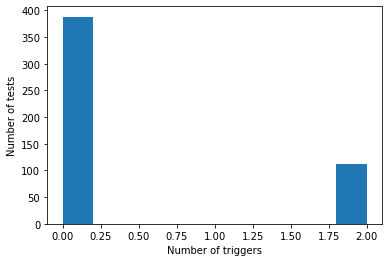

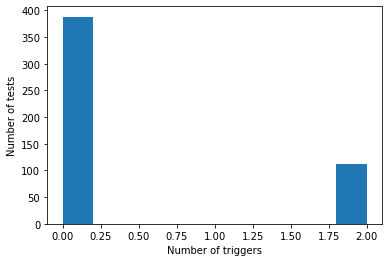

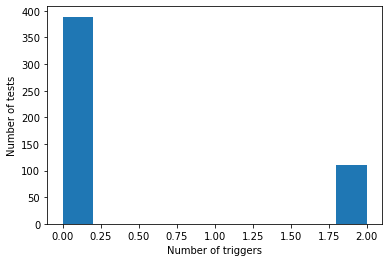

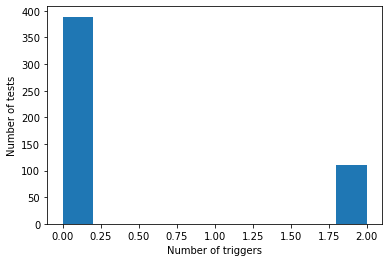

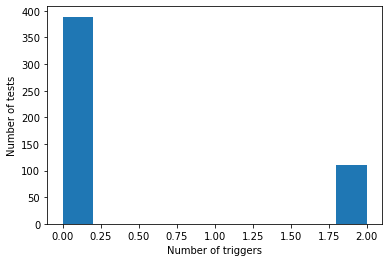

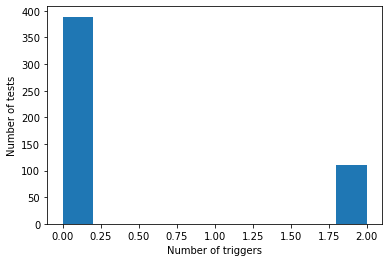

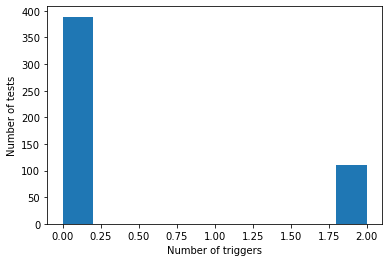

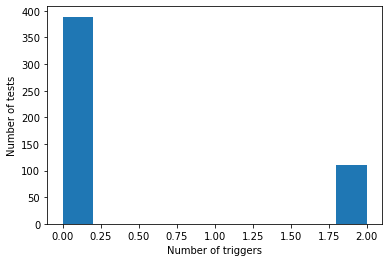

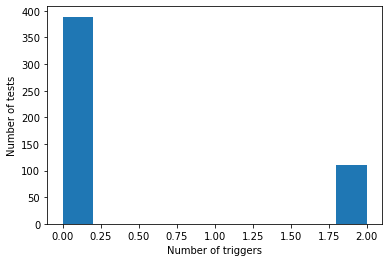

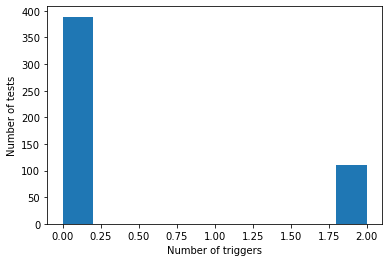

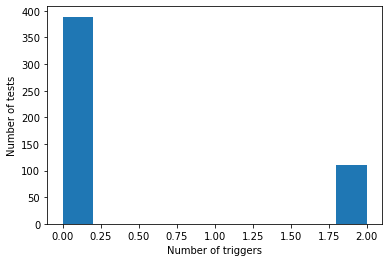

In [36]:
for j in range(11):
    plt.figure()
    plt.hist(countresults[:,j,j])
    plt.xlabel('Number of triggers')
    plt.ylabel('Number of tests')

for j in range(11):
    for i in range(11):
        if i!=j:
            for k in range(500):
                if countresults[k,j,i]!=1:
                    print (k,j,i, countresults[k,j,i])


Finally, I look at the distribution of times that it takes for the trigger to make it around the loop.

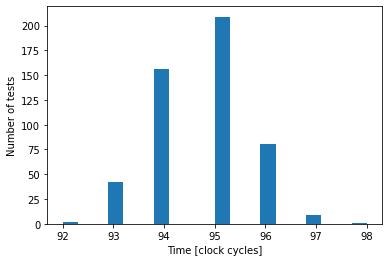

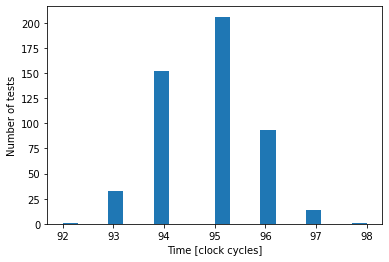

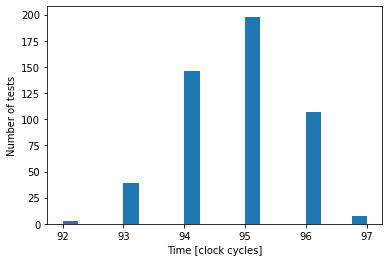

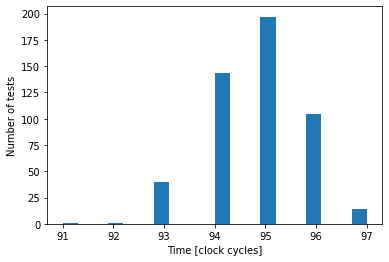

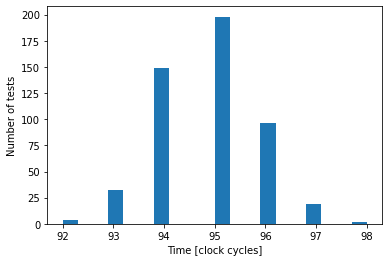

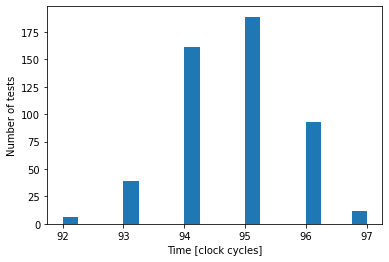

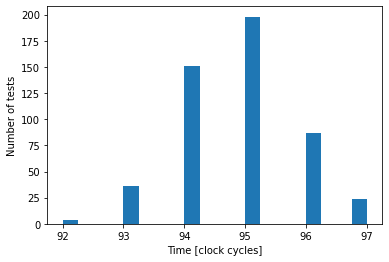

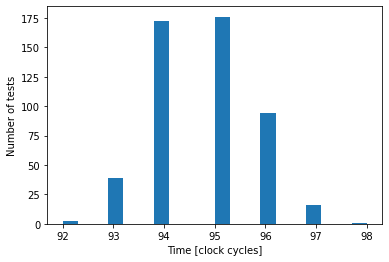

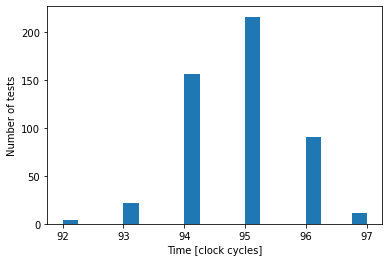

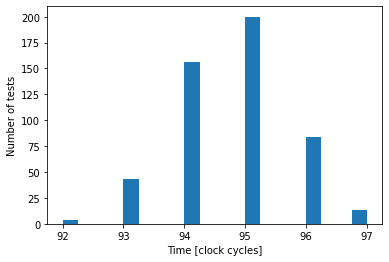

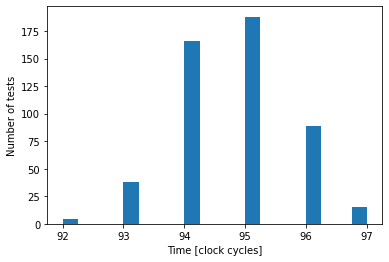

In [36]:
for j in range(11):
    plt.figure()
    plt.hist(timervaluesresults[:,j],20)
    plt.xlabel('Time [clock cycles]')
    plt.ylabel('Number of tests')

## Start long test with no triggers, to check for spurious signals
Ran from about 4:40 pm March 30 to 10:46am March 31

In [4]:
#Set up test
#reset_trigger_counter_all(brds)
#reset_trigger_timer_all(brds)
#reset_to_listen_all(brds)
#initialstates=read_state_value_all(brds)

In [12]:
print(initialstates)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [13]:
#Check for triggers
counts=read_trigger_counter_all(brds)
finalstates=read_state_value_all(brds)
print(counts)
print(finalstates)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
